In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import scipy
import sklearn
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 50)
%matplotlib inline

### This was tuned for Yelp, and performed fairly well with Amazon; with IMDB it wasn't good at all.  Switching to either puts some holes in the correlation matrix too.

In [2]:
# Raw reviews; [pos] indicates whether review was positive or not, 1 being true/positive
rev_raw = pd.read_csv('sentiment/yelp_labelled.txt', delimiter= '\t', header=None)
#rev_raw = pd.read_csv('sentiment/amazon_cells_labelled.txt', delimiter= '\t', header=None)
#rev_raw = pd.read_csv('sentiment/imdb_labelled.txt', delimiter= '\t', header=None)

rev_raw.columns = ['review', 'pos']

In [3]:
rev_raw.head()

,review,pos
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [16]:
# ALL CAPS are used in limited ways in these reviews, so using them would take some engineering; 
# I'm choosing to just go all lower caps instead to simplify things.
rev_raw['review'] = rev_raw['review'].str.lower()

# Seemed like positive reviews were easier to get than negative ones, but in a subsequent iteration
# I'll try negatives too and see how they compare.  I'd like to do both in one go too.
# I did do some grouping here of similar terms, rather than ending up with 50 different columns.
positives = ([r"\bloved?\b", "love"],
             [r"\b(great|best)\b", "great"],
             [r"\b(delicious|tender|tasty)\b", "delicious"],
             [r"\bamaz(ed|ing)\b", "amazing"],
             [r"\b(killer|excellent)\b", "killer"],
             [r"\benjoy(ed)?\b", "enjoy"],
             [r"\bprompt\b", "prompt"],
             [r"[^t] recommend(ed)?\b", "recommend"],
             [r"m{3,}\b", "mmm"],
             [r"\bgood prices?\b", "price"],
             [r"\bdelight(ed|ful)?\b", "delight"],
             [r"\bhighlight\b", "highlight"],
             [r"\bperfect(ed)?\b", "perfect"],
             [r"[^t](are|is|was|so)? good\b", "good"],
             [r"\b(go to places?|you must get)\b", "go to"],
             [r"\bwonderful\b", "wonderful"],
             [r"\bfav(orites?)?\b", "fav"])

# Create a new feature for each, and see if the keyword/s are in the review
for pattern, word in positives:
    rev_raw[str(word)] = rev_raw['review'].str.contains(pattern, case=False)
    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [5]:
# Will get to this later, figure out how to double-check with negative words

#negatives = (r"\bnast(y|iness)\b",
#             r"\byuck(y|iness)\b",
#             r"\bdisappoint(ed)?\b",
#             r"awful(ly)?\b",
#             r"\bbland\b")

#for pattern in negatives:
#    rev_raw.loc[:, ['love':]] = rev_raw['review'].str.contains(pattern, case=False)

In [17]:
# Have a look at only positive or negative reviews (set to 1 or 0 as desired)
rev_raw[rev_raw['pos'] == 1]

,review,pos,love,great,delicious,amazing,killer,enjoy,prompt,recommend,mmm,price,delight,highlight,perfect,good,go to,wonderful,fav
0,wow... loved this place.,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,stopped by during the late may bank holiday of...,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,the selection on the menu was great and so wer...,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,the fries were great too.,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,a great touch.,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10,service was very prompt.,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
13,"i tried the cape cod ravoli, chicken,with cran...",1,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
16,highly recommended.,1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
21,"the food, amazing.",1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
22,service is also cute.,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


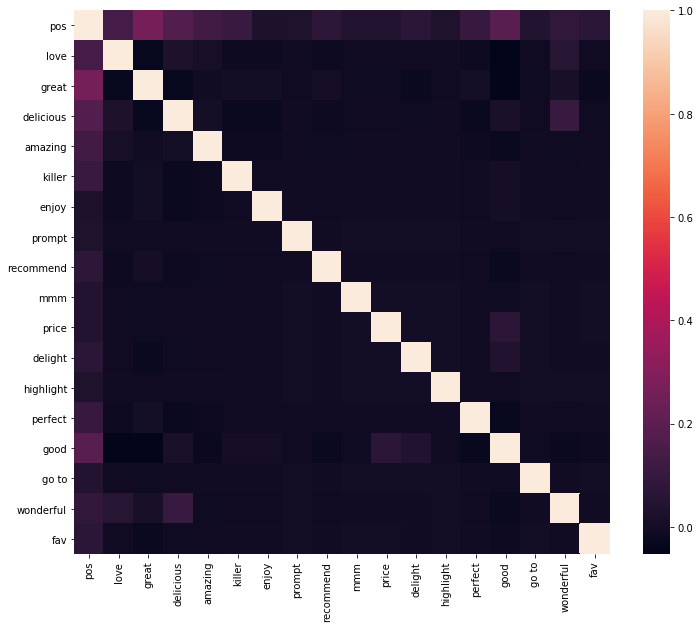

In [18]:
# Correlation Matrix, doesn't look bad
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(rev_raw.corr())
plt.show()

In [19]:
# set up the data and target for sklearn
data = rev_raw.loc[:, "love":]
target = rev_raw['pos']

In [20]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier. I brought
# in the rest for testing
from sklearn.naive_bayes import BernoulliNB
#from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import ComplementNB
#from sklearn.naive_bayes import MultinomialNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()
#bnb = GaussianNB()
#bnb = ComplementNB()
#bnb = MultinomialNB()

# Fit the model to the data
bnb.fit(data, target)

# Classify and store the result
y_pred = bnb.predict(data)

print(f"Correct points out of a {data.shape[0]} total: {(target == y_pred).sum()}")

Correct points out of a 1000 total: 729


### I know I could do better if I kept iterating, but would end up just hand-matching every review with a longer and longer list of regexps...  I doubt that's what is desired.  I looked ahead and put a confusion matrix here for grins.

In [21]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(target, y_pred)

#print(cf, "\n")              # uncomment to see the matrix itself
print(f"{cf[0,0]} true positives, and {cf[0,1]} false positives")
print(f"{cf[1,0]} true negatives, and {cf[1,1]} false negatives")

471 true positives, and 29 false positives
242 true negatives, and 258 false negatives
